## Sagnac Frequency - Backscatter Correction - RU backscatter

Explore the longterm behaviour of the RU sagnac beat

## Imports

In [2]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from andbro__load_FURT_stream import __load_furt_stream

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [4]:
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data

## Configurations

In [5]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

# hardly jumps or splits
config['tbeg'] = UTCDateTime("2024-02-14 12:00")
config['tend'] = UTCDateTime("2024-02-22 00:00")
flim1, flim2 = 302.40, 302.46

# splits
# config['tbeg'] = UTCDateTime("2024-03-26 12:00")
# config['tend'] = UTCDateTime("2024-03-30 21:00")
# flim1, flim2 = 302.40, 302.50

#
# config['tbeg'] = UTCDateTime("2024-03-31 18:00")
# config['tend'] = UTCDateTime("2024-04-03 00:00")
# flim1, flim2 = 302.42, 302.50


# config['tbeg'] = UTCDateTime("2024-04-20 18:00")
# config['tend'] = UTCDateTime("2024-04-30 00:00")
# flim1, flim2 = 302.41, 302.49


config['tbeg'] = UTCDateTime("2024-05-02 00:00")
config['tend'] = UTCDateTime("2024-05-05 00:00")
flim1, flim2 = 302.41, 302.49



## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

## Configurations

In [6]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240505_00:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240505_01:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240505_02:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240505_03:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240505_04:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240505_05:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagnac_frequency/data/FJU_20240505_06:00:00_backscatter.pkl
 -> failed: /home/andbro/kilauea-data/sagnac_frequency/data/backscatter/sagn

### Compute Backscatter (again)

In [7]:
from functions.backscatter_correction import __backscatter_correction

In [8]:
# unwrap phases as one time series
bs['fj_ph'] = np.unwrap(bs.fj_ph)
bs['f1_ph'] = np.unwrap(bs.f1_ph)
bs['f2_ph'] = np.unwrap(bs.f2_ph)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.033)

(302.41, 302.49)

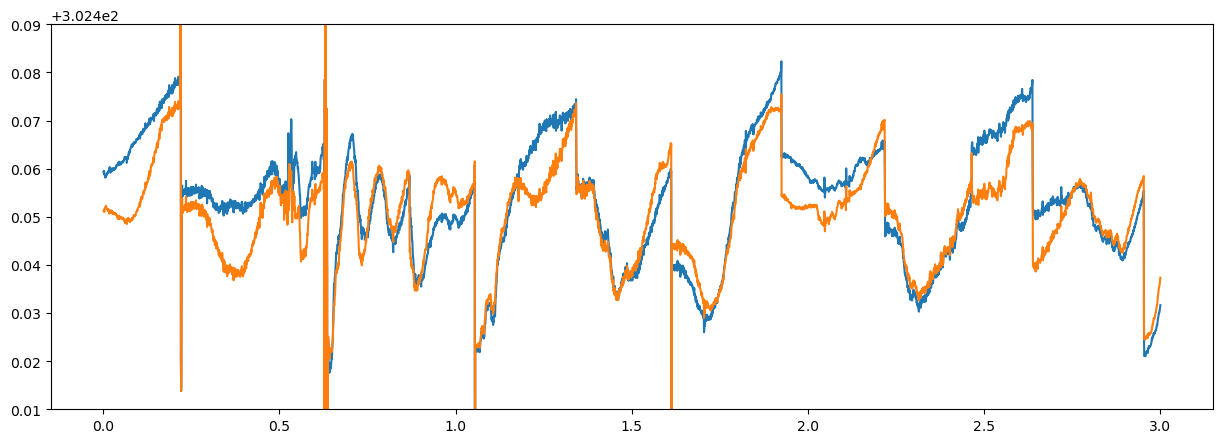

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.plot(bs.time_sec/86400, bs.fj_bs)

# plt.plot(bs.time_sec/86400, gaussian_filter1d(bs.fj_bs, 2))

plt.ylim(flim1, flim2)

### Cut corrupt data periods

In [10]:
times = [("2023-12-04T09:11", "2023-12-04T18:01")]

for t1, t2 in times:
    bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
    bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_bs)


bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
bs['fj_bs'] = np.nan_to_num(bs['fj_bs'], nan=np.nanmedian(bs['fj_bs']))

In [11]:
from functions.load_mlti import __load_mlti

mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [12]:
from functions.get_mlti_intervals import __get_mlti_intervals

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [13]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)
bs = __mlti_intervals_to_NaN(bs, "fj_bs", "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)

### Apply special filter sections

In [14]:
tt1, tt2 = "2023-11-01", "2023-11-07 17:00"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.95
cond4 = bs.fj_fs_nan > 303.1

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [15]:
tt1, tt2 = "2023-11-07 17:00", "2023-11-20 14:00"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.7
cond4 = bs.fj_fs_nan > 303.0

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [16]:
tt1, tt2 = "2023-11-20 14:00", "2024-01-11"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.4
cond4 = bs.fj_fs_nan > 302.6

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [17]:
tt1, tt2 = "2023-12-20 00:00", "2024-02-22"
cond1 = bs.time1 > tt1
cond2 = bs.time1 < tt2
cond3 = bs.fj_fs_nan < 302.38
cond4 = bs.fj_fs_nan > 302.48

bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [18]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [19]:
from functions.smoothing import __smooth

n_minutes = 300

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

### Load LXX maintenance

In [20]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [21]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Checkup Plot

/tmp/ipykernel_547216/3069509830.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tcklbls)


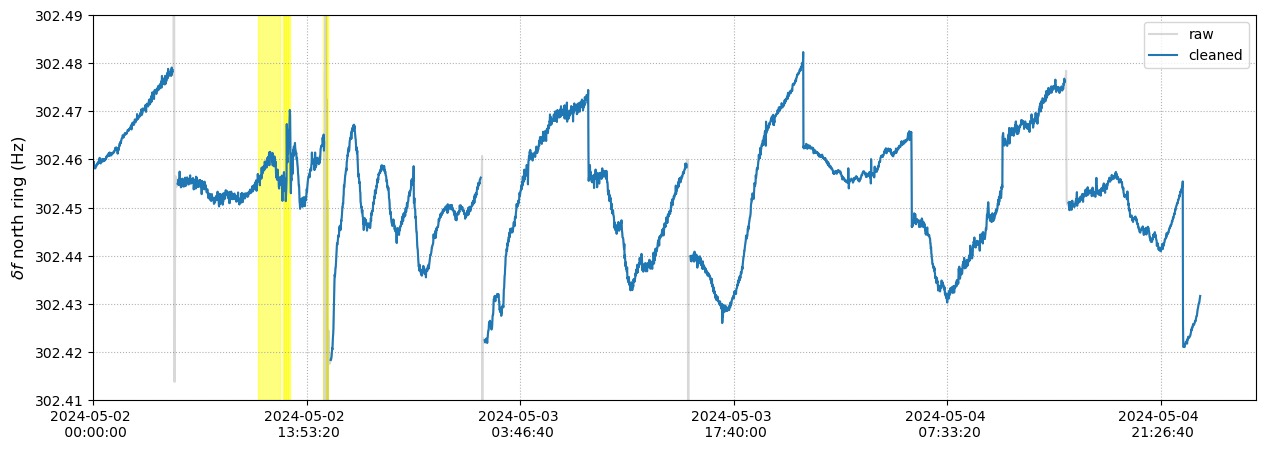

In [22]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1
    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)

    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax.set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_longterm_cleaned.png", format="png", dpi=150, bbox_inches='tight')


In [23]:
from functions.multitaper_psd import __multitaper_psd
from scipy.signal import detrend

dat1 = detrend(bs.fj_fs_inter, type="linear")
dat2 = detrend(bs.fj_bs_inter, type="linear")

# f1, psd1 = __multitaper_psd(dat1, 60, n_win=10, time_bandwidth=3.5)
# f2, psd2 = __multitaper_psd(dat2, 60, n_win=10, time_bandwidth=3.5)

# f1, psd1 = __welch_psd(dat1, 60, twin_sec=86400)
# f2, psd2 = __welch_psd(dat2, 60, twin_sec=86400)

f1, psd1, pha1 = __get_fft(dat1, 60)
f2, psd2, pha2 = __get_fft(dat2, 60)


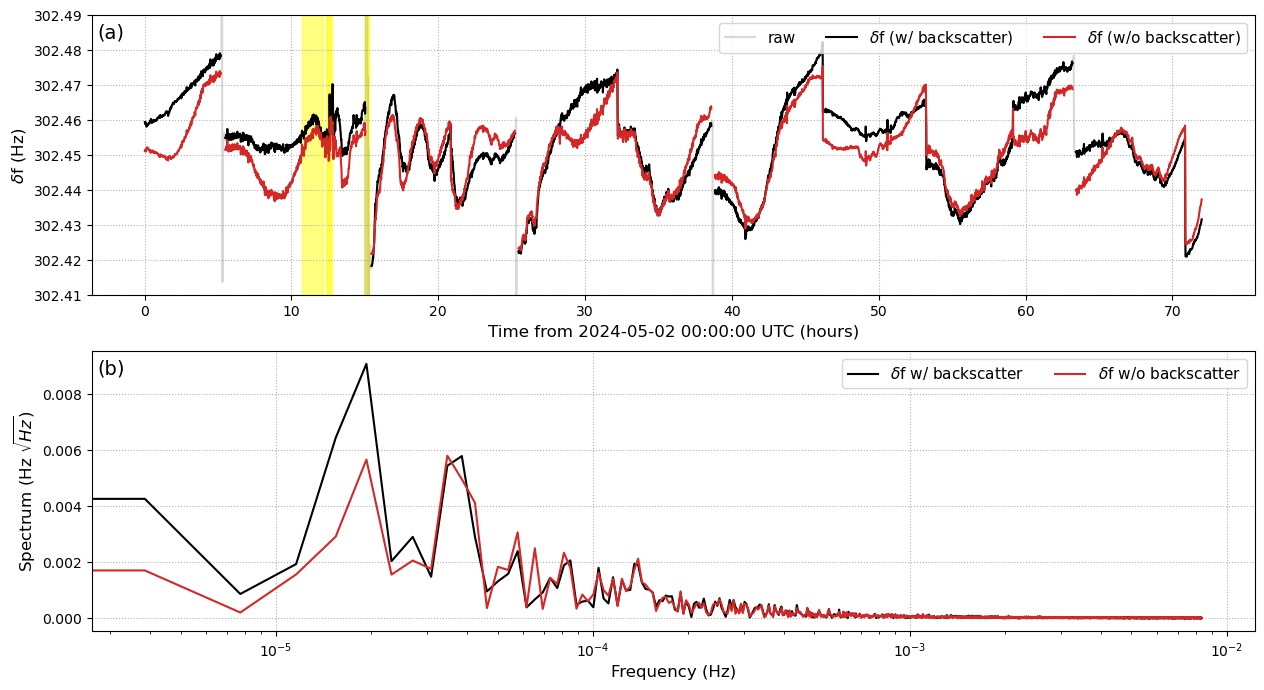

In [24]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    tscale, tunit = 1/3600, "hours"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax[0].plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")

    ax[0].ticklabel_format(useOffset=False)

    ax[1].semilogx(f1, psd1, color="black", label=f"$\delta$f w/ backscatter")
    ax[1].semilogx(f2, psd2, color="tab:red", label=f"$\delta$f w/o backscatter")

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1, ncol=3)

    ax[0].set_ylim(flim1, flim2)


    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC ({tunit})", fontsize=font)

    # ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)
    ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)

    # ax[1].axvline(1/(6*3600), ls="--", color="grey", zorder=0)
    # ax[1].axvline(1/(14*3600), ls="--", color="grey", zorder=0)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax[0].fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_backscatter_spectrum_{config['tbeg']}_{config['tend']}.png", format="png", dpi=200, bbox_inches='tight')


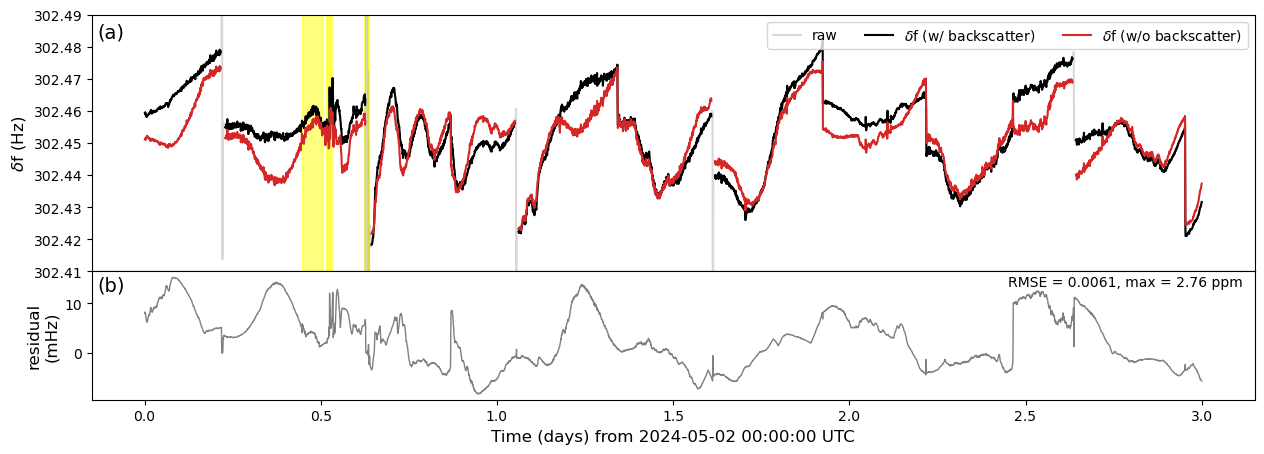

In [25]:
def __makeplot_residual():

    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.gridspec import GridSpec
    from functions.multitaper_psd import __multitaper_psd
    from functions.welch_psd import __welch_psd

    def __integrate(stt, dat):
        _st = stt.copy()
        _st.data = dat
        _st.integrate()
        return _st.data

    def __rmse(arr1, arr2):
        return np.round(np.sqrt(np.mean((arr1-arr2)**2)), 4)

    def __get_residual_percent(dat1, dat2):
        imax, vmax = np.argmax(abs(dat2-dat1)), np.amax(abs(dat2-dat1))
        pmax = round(np.amax(dat2-dat1)/dat1[imax]*100000, 2)
        return pmax



    def __to_dB(psd):
        return 10*np.log10(psd)

    def __get_lim(arrs):
        mins = [min(arr) for arr in arrs]
        maxs = [max(arr) for arr in arrs]
        return min(mins + maxs), max(mins + maxs)


    tscale, tunit = 1/86400, "days"


    Ncol, Nrow = 1, 3

    font = 12

    lw = 1

    scale, unit = 1, f"Hz"

    fig = plt.figure(figsize=(15, 5))

    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0)

    ax1 = fig.add_subplot(gs[0:2, :])
    ax2 = fig.add_subplot(gs[2, :])

    ax1.plot(bs.time_sec*tscale, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax1.plot(bs.time_sec*tscale, bs.fj_fs_nan, color="black", label=f"$\delta$f (w/ backscatter)")
    ax1.plot(bs.time_sec*tscale, bs.fj_bs_nan, color="tab:red", label=f"$\delta$f (w/o backscatter)")

    ax2.plot(bs.time_sec*tscale, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", lw=lw)
    # ax2.fill_between(bs.time_sec*tscale, 0, ( bs.fj_fs-bs.fj_bs )*1e3, color="grey", alpha=0.3)

    ax1.set_ylim(flim1, flim2)
    ax1.ticklabel_format(useOffset=False)
    ax1.legend(loc=1, ncol=3)

    ax1.set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    ax2.set_ylabel(f"residual\n(mHz)", fontsize=font)

    for ax in [ax1]:
        ax.get_xaxis().set_visible(False)

    ax2.set_xlabel(f"Time ({tunit}) from {config['tbeg'].date} {str(config['tbeg'].time).split('.')[0]} UTC", fontsize=font)

    ax1.text(.005, .97, "(a)", ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.005, .97, "(b)", ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    txt = f"RMSE = {__rmse(bs.fj_fs, bs.fj_bs)}, max = {__get_residual_percent(bs.fj_fs, bs.fj_bs)} ppm"
    ax2.text(.99, .97, txt, ha='right', va='top', transform=ax2.transAxes, fontsize=font-2)

    # ax1.set_title(f"{til_in[0].stats.station} & {acc_in[0].stats.station} | f = {fmin} - {fmax} Hz")

    # ax1.grid(ls=":", zorder=0)
    # ax2.grid(ls=":", zorder=0)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax1.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.plot();
    return fig

fig = __makeplot_residual()

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_backscatter_residual_{config['tbeg']}_{config['tend']}.png", format="png", dpi=200, bbox_inches='tight')
